### intro

The main idea in this task: build a model which predicts (extrapolates) user ratings of all music tracks for a given context, i.e. with known values of context dimensions (features). The goal is to choose most suitable tracks for a given context.

The main problem in the analyzed rating-context dataset is incompleteness of its user-item rating matrix $r_{nm}$ ($r$ matrix is relatively sparse). Thus, the model is feed by limited numbers of user ratings with limited context configurations $c$. Simply, we have ratings only for limited number of (user, item) pairs in limited context cases (configurations). 

This problem is related to known in literature Top-$N$ recommendation problem:<br> 
For a user-item ratings matrix $r$ and a given user with items $u$ that the he/she has rated, find recommendation for other $N$ items that he/she might like.

Typical approach, so-called Collaborative filtering (CF):
- find similar users and collect items they rate
- filter out those items the user has rated
- rang the remaining items by considering: popularity of the item, associated ratings, similarity between each item and user past choices (ratings)

Other approach (state of the art -- Netflix prize) is to compute the missing values of ratings using matrix factorization technique (MF)[1], by decomposing the user-item interaction matrix $r$ into the product of two lower dimensionality rectangular matrices.

Unfortunately, both of them do not utilize context. However, there are studies on generalizations of MF model to additional dimensions related to the context, and perform factorization of higher dimension objects -- tensor factorization (TF)[2].
***
Literature:

[1] Y. Zheng, A User's Guide to CARSKit, arxiv.org/abs/1511.03780 (2019).<br>
[2] A. Karatzoglou, X. Amatriain, L. Baltrunas, and N. Oliver, Multiverse recommendation: n-dimensional tensor factorization for context-aware collaborative filtering. In Proceedings of the fourth ACM conference on Recommender systems, pp. 79-86. ACM (2010).
***
Plan:

1.	Understanding of the data
2.	Building simple linear recommender model, context-oriented 
3.	We compare it with the MF model (where we are with our model, what amout of information the context introduces) <- TODO

In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

### data reading

In [2]:
class Data_reader(object):
    def __init__(self, dir_name, file_name):
        self._data=pd.read_excel(os.path.join(dir_name, file_name), sheet_name="ContextualRating") 
        self._data_labels=pd.read_excel(os.path.join(dir_name, file_name), sheet_name="Context Factor")
    @property
    def data(self):
        return self._data
    @data.setter
    def data(self, value):
        raise ValueError("Data cannot be changed") 
    @property
    def data_labels(self):
        return self._data_labels
    @data_labels.setter
    def data_labels(self, value):
        raise ValueError("Data labels cannot be changed")
    def cleaning_data(self):
        # cleaning:
        self._data_labels.columns=self._data_labels.columns.str.strip()
        self._data_labels.apply(lambda x: x.str.strip() if type(x) == str else None)
        self._data_labels['dimension']=self._data_labels['dimension'].str.strip()
        self._data.columns=self._data.columns.str.strip() 

dr = Data_reader(os.path.dirname(os.path.realpath("results.ipynb")), os.path.realpath("Data_InCarMusic.xlsx"))
dr.cleaning_data()

In [3]:
class Context_features:
    def __init__(self):
        dims = dr.data_labels['dimension'].unique()
        vals = []
        vals_size = []
        for i, dim in enumerate(dims):
            vals.append(dr.data_labels.loc[dr.data_labels['dimension'] == dim]['value'].str.strip().to_numpy())
            vals_size.append(vals[i].size)
        self.dims = dims
        self.dims_size = dims.size         
        self.vals = np.array(vals)
        self.vals_size = np.array(vals_size)

class Items:
    def __init__(self, item):
        items = np.sort(dr.data[item].unique())
        self.items = items
        self.items_size = items.size

### extracting the context features and their values

In [4]:
c_feat = Context_features() 
for i, dim in enumerate(c_feat.dims):
    print dim + ":"
    for j in range(c_feat.vals_size[i]):
        print "- " + c_feat.vals[i][j]

driving style:
- relaxed driving
- sport driving
landscape:
- coast line
- country side
- mountains
- urban
mood:
- active
- happy
- lazy
- sad
natural phenomena:
- afternoon
- day time
- morning
- night
road type:
- city
- highway
- serpentine
sleepiness:
- awake
- sleepy
traffic conditions:
- free road
- lots of cars
- traffic jam
weather:
- cloudy
- rainy
- snowing
- sunny


### correlations between ratings and context dimensions - which context features biases ratings at most
We calculate standard deviation (sigma) of ratings between context variables $v$, averaged over users (numbered by $n$) and items ($m$), for different context features $c_k$: 
$$\sigma^0_k=\sigma\left[\langle r_{nm}\rangle_{nm}(c_k=v)\right]_v,$$
where $r_{nm}$ is so-called user-item rating matrix.

driving style:
- relaxed driving 2.28 (1.49)
- sport driving 2.35 (1.49)
mean:  2.318
sigma0:  0.036

landscape:
- coast line 2.46 (1.54)
- country side 2.03 (1.30)
- mountains 2.32 (1.49)
- urban 2.14 (1.32)
mean:  2.239
sigma0:  0.162

mood:
- active 2.21 (1.47)
- happy 2.41 (1.58)
- lazy 2.19 (1.44)
- sad 2.18 (1.52)
mean:  2.248
sigma0:  0.097

natural phenomena:
- afternoon 2.43 (1.37)
- day time 2.12 (1.33)
- morning 2.48 (1.51)
- night 2.79 (1.57)
mean:  2.454
sigma0:  0.238

road type:
- city 2.37 (1.39)
- highway 2.62 (1.55)
- serpentine 2.31 (1.47)
mean:  2.433
sigma0:  0.132

sleepiness:
- awake 2.76 (1.55)
- sleepy 2.07 (1.49)
mean:  2.417
sigma0:  0.347

traffic conditions:
- free road 2.56 (1.60)
- lots of cars 2.36 (1.48)
- traffic jam 1.86 (1.28)
mean:  2.262
sigma0:  0.297

weather:
- cloudy 2.38 (1.42)
- rainy 2.53 (1.54)
- snowing 2.22 (1.39)
- sunny 2.61 (1.58)
mean:  2.436
sigma0:  0.148



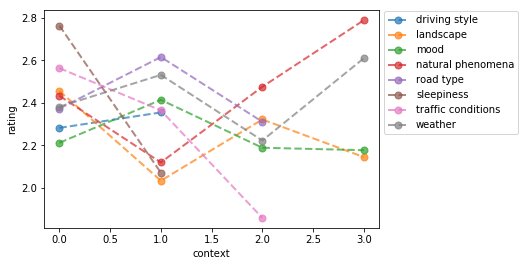

In [5]:
# correlations plot setup
fig, ax = plt.subplots()
ax.set_ylabel('rating')
ax.set_xlabel('context')
#
for i, dim in enumerate(c_feat.dims):
    print dim + ":"
    m = np.empty([c_feat.vals_size[i]])
    corr_plot = []
    for j in range(c_feat.vals_size[i]):
        m[j] = dr.data.loc[dr.data[dim] == c_feat.vals[i][j]]['Rating'].mean()
        corr_plot.append([j,m[j]])
        print "- " + c_feat.vals[i][j] + " %.2f " % m[j]\
                                + "(%.2f)" % dr.data.loc[dr.data[dim] == c_feat.vals[i][j]]['Rating'].std()
    corr_plot=np.array(corr_plot)
    ax.plot(corr_plot[:,0], corr_plot[:,1], 'o--', linewidth=2, markersize=7, alpha=0.7, label=dim)
    print "mean: " + " %.3f" % np.mean(m)
    print "sigma0: " + " %.3f" % np.std(m)
    print
ax.legend(bbox_to_anchor=(1., 1.02))
plt.show()

Results:

- some context features have larger impact on ratings than others, e.g. expressed opinion strongly depends on the traffic conditions while weakly on the driving style -- opinions rated during a traffic jam are in average lower than ratings on free road, while the driving style woluld not bias them.
- this means that ratings are biased by value of sleepiness, traffic conditions or natural phenomena, weakly biased by landscape, weather or road type, while mostly independent on value of driving style or mood
- such biasing of rating should be taken into account when constructing of the recommender model (some ratings normalization ???)
- mean ratings of different features should be similar -- ratings should not depend on which context feature is actually examined, thus, from deviations among means calculated for different context dimension, we can estimate ratings error. 
- there is no explicit information in the data about correlations between (different) context dimensions -- always single context feature is examined

### relations between ratings and subsequent tracks

In [6]:
def plot_ratings(axs_i, rn, c_feat, index, xlim, color_map):
    axs_i.scatter(x=rn[:,0], y=rn[:,1], c=rn[:,2], s=25, cmap=color_map)   
    # create legend
    legend = np.arange(c_feat.vals_size[index])
    legendx = [xlim*0.87]*c_feat.vals_size[index]
    legendy = legend+1.
    axs_i.scatter(x=legendx, y=legendy, s=25, c=legend, cmap=color_map)    
    for l in legend: axs_i.annotate(c_feat.vals[index][l],(legendx[l]+xlim*0.02,legendy[l]))
    #
    axs_i.set_xlim((0,xlim))
    axs_i.set_axis_off()
    
def plot_ratings_summary(axs, srn, vrn, xlim, sig):
    # summary rating:
    axs.scatter(x=range(srn.size), y=srn, s=vrn*25)
    axs.set_xlim((0,xlim))
    axs.set_xlabel(sig + '# n') 
    axs.set_ylabel('mean rating')
    
def plot_selected_with_axis(axs):
    axs.set_ylabel('rating')
    axs.set_axis_on()
    axs.xaxis.set_major_locator(plt.NullLocator())

def get_axes():
    # plot setup
    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9)
    fig.set_size_inches(13, 10)
    axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
    return axs
    
def calculate_ratings(data_i, item, axs, color_map):
    srm = np.empty([data_i.items_size,c_feat.dims_size])
    vrm = np.empty([data_i.items_size,c_feat.dims_size])
    for i, dim in enumerate(c_feat.dims):
        rm = []
        vm = np.empty([data_i.items_size])
        for m in range(data_i.items_size): 
            vj = np.empty([c_feat.vals_size[i]])
            for j in range(c_feat.vals_size[i]):
                vj[j] = dr.data.loc[(dr.data[dim] == c_feat.vals[i][j]) & (dr.data[item] == data_i.items[m])]['Rating'].mean()
                rm.append([m,vj[j],j])
            vj = list(filter(lambda x: ~np.isnan(x), vj)) # remove nans (where is no data -- r is sparse)
            vm[m] = np.std(vj)
            srm[m,i] = np.mean(vj)
            vrm[m,i] = vm[m]
        vm = list(filter(lambda x: ~np.isnan(x), vm))
        rm = np.array(rm)
        print dim + " sigma=" + "%.3f" % np.mean(vm)
        plot_ratings(axs[i], rm, c_feat, i, 1.2*data_i.items_size, color_map)
    return srm, vrm

def average_ratings(srm):
    srm[np.isnan(srm)] = 1. # default value
    srm = np.mean(srm, axis=1)
    return srm

driving style sigma=0.474
landscape sigma=0.666
mood sigma=0.643
natural phenomena sigma=0.599
road type sigma=0.523
sleepiness sigma=0.236
traffic conditions sigma=0.542
weather sigma=0.521


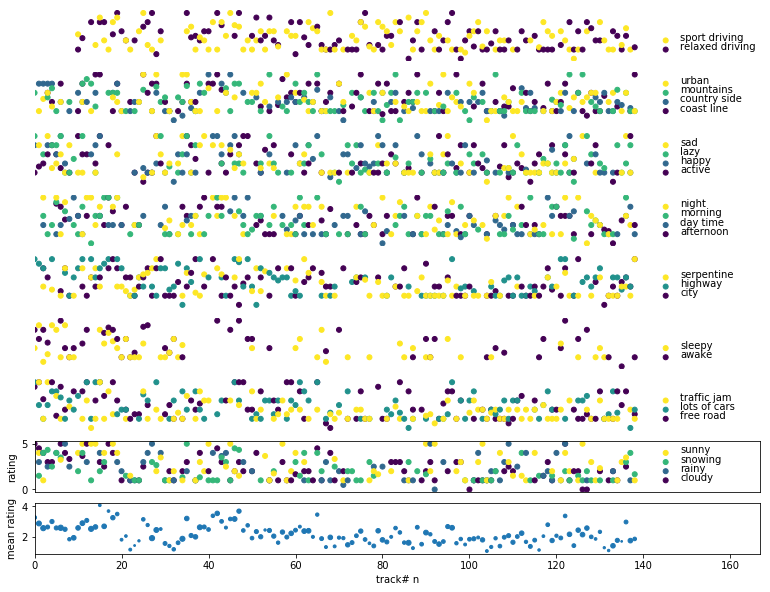

In [24]:
axs = get_axes()  
data_i = Items('ItemID')
srm, vrm = calculate_ratings(data_i, 'ItemID', axs, 'viridis')
plot_selected_with_axis(axs[7])
# summary rating:
srm = average_ratings(srm)
vrm = average_ratings(vrm)
plot_ratings_summary(axs[8], srm, vrm, 1.2*data_i.items_size, 'track')

plt.show()

Results:

We have plotted ratings averaged over users (numbered by $n$) for a various values $v$ of a given context dimension ($c_k$) and different track numbers $m$: $\langle r_{nm}\rangle_n(c_k=v)$
- people generally do not like hip-hop (m = 21-25) and heavy-metal (31-35) tracks, whereas they like disco (16-20) and reggae (41-46), and AC/DC ;)
- opinions about "golden oldies" (1-51) ale more polarized and with higher average ranks than the rest of tracks (52-139)
- some of context features are rather incomplete: sleepiness mostly, and driving style less
- calculating sigma (std. deviation) of rating between context variables, averaged over all tracks for different context features, characterizes how ratings variate within a given context dimension: 
$$\sigma_k=\frac{1}{|M|}\sum_{m} \sigma\left[\langle r_{nm}\rangle_n(c_k=v)\right]_v,$$
with $|M|$ denoting the number of tracks and $k$ numbering the context dimension.

The stronger dependence between ratings $\langle r_{nm}\rangle_n(c_k=v)$ and value $v$ of a given context $c_k$  we get, characterized by $\sigma_k$, the better context dimension $c_k$ is. Context features characterized from the best to the worst are: landscape, mood, natural phenomena, traffic conditions, road type, weather, driving style and sleepiness respectively.

### differences between users

driving style sigma=0.323
landscape sigma=0.594
mood sigma=0.711
natural phenomena sigma=0.556
road type sigma=0.475
sleepiness sigma=0.258
traffic conditions sigma=0.527
weather sigma=0.626


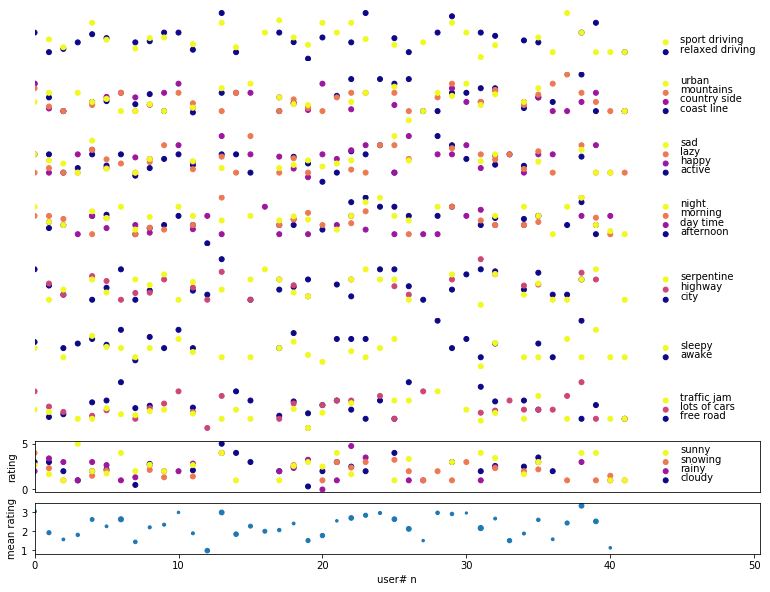

In [8]:
axs = get_axes()  
data_u = Items('UserID')
srn, vrn = calculate_ratings(data_u, 'UserID', axs, 'plasma')
plot_selected_with_axis(axs[7])
# summary rating:
srn = average_ratings(srn)
vrn = average_ratings(vrn)
plot_ratings_summary(axs[8], srn, vrn, 1.2*data_u.items_size, 'user')

plt.show()

Here we observe ratings made by different users averaged over all tracks:
$$\langle r_{nm}\rangle_m(c_k=v).$$
And $\sigma_k$ is calculated as:
$$\sigma_k=\frac{1}{|N|}\sum_{n} \sigma\left[\langle r_{nm}\rangle_m(c_k=v)\right]_v,$$
with $|N|$ denoting the number of all users and $k$ numbering the context dimension.

Results:
        
- some people are higher immune to context variability (small blue dots = small deviation with variuos $v$ for a given context feature), while some others are very sensitive to $v$ variations (big blue dots)
- landscape and traffic conditions are features that distinguish users at most (they give highest differences between deviations of each user, calculated as "deviaion of deviations"):
$$\sigma\left[\sigma\left[\langle r_{nm}\rangle_m(c_k=v)\right]_v\right]_n,$$
- there is high discrepancy among users in average ratings they give (see blue dots)

### simple linear recommender model

We propose a simple linear model of recommender that takes into account fact that ratings may depend on context features values. It is linear because we simply sum over all context dimensions without considering correlations between them. The model assumes that ratings of all users are simmilar. Recommendation for $m$-th track is calculated as:

$$R^\alpha_m(\mathbf v)=(1-\alpha)\langle r_{nm}\rangle_{nk}+\alpha\sum_k w_{mk}\,\langle r_{nm}\rangle_n(c_k=v_k),$$
with weights for $k$-th context feature:
$$w_{mk}=\frac{1}{\sum_k w_{mk}}\sigma\left[\langle r_{nm}\rangle_m(c_k=v_k)\right]_{v_k},$$
for a given context configuration $\mathbf{v} = (v_k)$.
Parameter $\alpha\in[0,1]$ turns on ($\alpha=1$) or turns off ($\alpha=0$) the context impact.

In [9]:
# recommender model
def recommend(context, r_mkj, w_mk, r_m, alpha):
    rc_m = np.zeros([r_m.size])
    d_context = int(np.sum(map(lambda x: 0 if x < 0 else 1, context))) # number of filled dimensions  
    if(d_context == 0): rc_m = r_m  # context is empty
    elif(d_context < context.size): # context is partially filled
        new_weight = np.zeros([r_m.size])
        for k, cont in enumerate(context): 
            if(cont >= 0):
                rc_m += w_mk[:,k]*r_mkj[:,k,cont]
                new_weight += w_mk[:,k]
        rc_m /= new_weight
    else:                           # context is fully filled
        #for m in range(items.size):
        #    for k in range(context.size):
        #        rc_m[m]+=w_mk[m,k]*r_mkj[m,k,context[k]]        
        for k, cont in enumerate(context): rc_m += w_mk[:,k]*r_mkj[:,k,cont]            
    rc_m = r_m*(1.-alpha) + rc_m*alpha   
    return rc_m

def recommend_m(context, r_mkj, w_mk, r_m, alpha, m):
    rc = 0.
    d_context = int(np.sum(map(lambda x: 0 if x < 0 else 1, context))) # number of filled dimensions  
    if(d_context == 0): rc = r_m[m] # context is empty
    elif(d_context < context.size): # context is partially filled
        new_weight = 0.
        for k, cont in enumerate(context): 
            if(cont >= 0):
                rc += w_mk[m,k]*r_mkj[m,k,cont]
                new_weight += w_mk[m,k]
        rc /= new_weight
    else:                           # context is fully filled
        for k, cont in enumerate(context): rc += w_mk[m,k]*r_mkj[m,k,cont]
    rc = r_m[m]*(1.-alpha) + rc*alpha
    return rc

# gathering the coefficient matrices
def extract_coef(test_data):
    r_mkj = np.zeros([data_i.items_size,c_feat.dims_size,np.max(c_feat.vals_size[:])])
    w_mk = np.empty([data_i.items_size,c_feat.dims_size])
    r_m = np.empty([data_i.items_size])
    for m in range(data_i.items_size): # average values (context discarded)
        r_m[m] = test_data.loc[test_data['ItemID'] == data_i.items[m]]['Rating'].mean()
    for k, dim in enumerate(c_feat.dims):
        for m in range(data_i.items_size): 
            vj = np.empty([c_feat.vals_size[k]])
            for j in range(c_feat.vals_size[k]):
                df = test_data.loc[(test_data[dim] == c_feat.vals[k][j]) & (test_data['ItemID'] == data_i.items[m])]['Rating']            
                vj[j] = df.mean() if df.size > 1 else r_m[m]
                r_mkj[m,k,j] = vj[j]
            w_mk[m,k] = np.std(vj) + 1. #  + 1. in case of zero weights   
    # normalizing weights
    for m in range(data_i.items_size):
        sm = np.sum(w_mk[m,:])
        w_mk[m,:] /= sm
    return r_mkj, w_mk, r_m 

# model validation
def validate_model(train_data,test_data,alpha):
    r_mkj, w_mk, r_m = extract_coef(train_data)
    err = 0.
    for i, datum in test_data.iterrows():
        real_rating = datum['Rating']
        m = data_i.items.tolist().index(datum['ItemID'])
        context = np.zeros([c_feat.dims_size], dtype=np.int16)
        for k, dim in enumerate(c_feat.dims):
            if(isinstance(datum[dim], unicode)): 
                context[k] = c_feat.vals[k].tolist().index(datum[dim])
            else: context[k] = -1               
        predicted_rating = recommend_m(context, r_mkj, w_mk, r_m, alpha, m)
        err += (real_rating-predicted_rating)**2
    return np.sqrt(err)

# divide for k-fold cross-validation
def divide_dataset(dataset,k):
    df_list = [pd.DataFrame()]*k
    for i, datum in dataset.iterrows(): 
        rnd = np.random.randint(k)
        df_list[rnd] = df_list[rnd].append(datum)        
    return df_list

# k-fold cross-validation
def cross_validation(dataset,k,alpha):
    df_list = divide_dataset(dataset,k)
    #print data.size, "samples divided to:"
    #for i in range(k): print ">", df_list[i].size
    err = 0.
    for i in range(k):
        test_data = df_list[i]
        train_data = list(df_list)
        del train_data[i]
        train_data = pd.concat(train_data)
        err += validate_model(train_data,test_data,alpha)
        #print str(k)+"-fold validation:", i+1 , " ...done"
    return err/k

### model validation

In [21]:
validation_k = 10 # number of k-validation subsets
alpha_ntics = 11 # divide [0,1] range
alpha_dx = 1./(alpha_ntics-1)
err = np.empty([alpha_ntics,2])

#### naive validation

validation for alpha = 0.0 ...
validation for alpha = 0.1 ...
validation for alpha = 0.2 ...
validation for alpha = 0.3 ...
validation for alpha = 0.4 ...
validation for alpha = 0.5 ...
validation for alpha = 0.6 ...
validation for alpha = 0.7 ...
validation for alpha = 0.8 ...
validation for alpha = 0.9 ...
validation for alpha = 1.0 ...


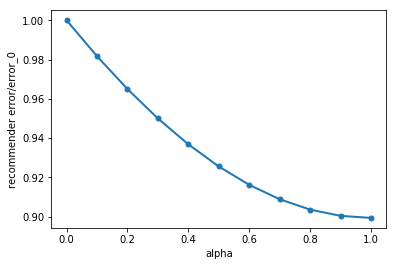

In [22]:
for i in range(alpha_ntics):
    alpha = alpha_dx*i
    print "validation for alpha =", alpha, "..."
    err[i,0] = alpha
    err[i,1] = validate_model(dr.data,dr.data,alpha)
err[:,1] /= err[0,1] # normalization
# plot results
fig, ax = plt.subplots()
ax.set_ylabel('recommender error/error_0')
ax.set_xlabel('alpha')
ax.plot(err[:,0], err[:,1], 'o-', linewidth=2, markersize=5)
plt.show()

Results:

In naive approach to validation we assume that train_subset is equal to test_subset, and the both contain whole data:
- we observe that taking context into account, by setting $\alpha>0$, make rating predictions better and lowers model inaccuracy

#### proper validation

validation for alpha = 0.0 ...
validation for alpha = 0.1 ...
validation for alpha = 0.2 ...
validation for alpha = 0.3 ...
validation for alpha = 0.4 ...
validation for alpha = 0.5 ...
validation for alpha = 0.6 ...
validation for alpha = 0.7 ...
validation for alpha = 0.8 ...
validation for alpha = 0.9 ...
validation for alpha = 1.0 ...


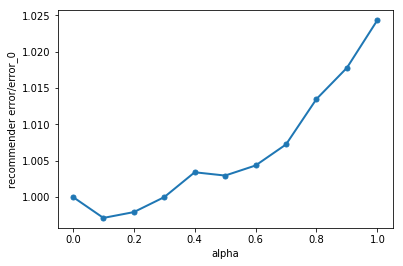

In [23]:
for i in range(alpha_ntics):
    alpha = alpha_dx*i
    print "validation for alpha =", alpha, "..."
    err[i,0] = alpha
    err[i,1] = cross_validation(dr.data,validation_k,alpha)
err[:,1] /= err[0,1] # normalization
# plot results
fig, ax = plt.subplots()
ax.set_ylabel('recommender error/error_0')
ax.set_xlabel('alpha')
ax.plot(err[:,0], err[:,1], 'o-', linewidth=2, markersize=5)
plt.show()

Results:

To proper validate the model we utilize k-fold cross validation technique, with $k=10$ validation subsets assumed.
Unfortunatelly, in this case the model works much worse.
- probably reason of this is to small data set, simply, when calculating average rating for a given feature value (for a given track number $m$) there ale typicaly only a few, usually 2-5 samples, that meets given feature value criterion. This is not enough to resonably estimate average value.
 - we need more data ;)
 - obtainig data with more than one context feature specified would be beneficial
- there is optimum value of $\alpha$ with the best model accuracy

Possible model improvements:
- taking into differences between users, i.e. calculate averages within ensemble of k-nearest users. We need to define metric determining "distance" -- difference between users
- normalization of ratings, see section "correlations between ratings and context dimensions - which context features biases ratings at most", possibly improove the accuracy

TODO:

- compare the model with (state-of the art) MF model, and its variations that utilize context
    